In [1]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.19.0


In [2]:
# 0: 'angry',
# 1: 'happy',
# 2: relaxed',
# 3: 'sad'

import os
driver_image_path = r'C:\Users\U2SR\Desktop\Udemy\tensorflow-cnn\Dog Emotion'
class_names = sorted(os.listdir(driver_image_path))
print(class_names)

['angry', 'happy', 'relaxed', 'sad']


In [ ]:
import cv2
imageee = cv2.imread(r'C:\Users\U2SR\Desktop\Udemy\tensorflow-cnn\Dog Emotion\angry\0aNyXBrmNA7XdefwHvgO2n1rnpqQAp885.jpg')
imageee.shape

(400, 440, 3)

In [8]:
img_size = (200, 200, 3)

images = []
labels = []

for class_name in class_names:
    images_files_folder_name = os.path.join(driver_image_path, class_name)
    if os.path.isdir(images_files_folder_name):
        for image_name in os.listdir(images_files_folder_name):
            if image_name.lower().endswith('.jpg'):
                image_full_path = os.path.join(images_files_folder_name, image_name)
                
                img = cv2.imread(image_full_path)
                if img is None:
                    continue
                
                img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img_cvt, img_size[:2])
                
                images.append(img_resized)
                labels.append(class_names.index(class_name))

print(f"Total images : {len(images)}, Total labels : {len(labels)}")

Total images : 3975, Total labels : 3975


In [9]:
import numpy as np
images = np.asarray(images)
labels = np.asarray(labels)

In [10]:
from sklearn.model_selection import train_test_split
X_train , X_val , y_train , y_val = train_test_split(images , labels , test_size = 0.2)

In [11]:
import tensorflow as tf
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.05),             #랜덤 회전
    tf.keras.layers.RandomFlip(mode='horizontal'),           #랜덤 수평 플립
    tf.keras.layers.RandomContrast(factor=0.2),              #랜덤 대비 조정
])

In [12]:
#이미지 크기를 지정된 크기로 조정해주는 함수
def preprocessing_image(image , label):
  image = tf.image.resize(image , img_size[:2])
  return image , label

#이미지에 이미지 증강을 적용해주는 함수
def augment_image(image , label):
  image = data_augmentation(image)
  return image , label

#이미지와 레이블을 tensorflow dataset으로 변환하고, 전처리 및 증강을 적용하여 배치와 프리패칭을 설정하는 함수
def create_tensorflow_dataset(images ,labels , batch_size = 32 , buffer_size = 1000 , augment = False):
  dataset = tf.data.Dataset.from_tensor_slices((images , labels))
  dataset = dataset.map(preprocessing_image , num_parallel_calls = tf.data.AUTOTUNE)
  if augment:
    dataset = dataset.map(augment_image , num_parallel_calls = tf.data.AUTOTUNE)
  dataset = dataset.shuffle(buffer_size)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
  return dataset

In [15]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU 탐색
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    global_batch_size = 32 * tpu_strategy.num_replicas_in_sync
else:
    global_batch_size = 32

In [16]:
train_dataset = create_tensorflow_dataset(X_train , y_train , batch_size = global_batch_size , buffer_size = len(X_train) , augment = True)
val_dataset = create_tensorflow_dataset(X_val , y_val , batch_size = global_batch_size , buffer_size = len(X_val) , augment = False)

In [19]:
img_size = (200, 200, 3)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=img_size),
    tf.keras.layers.Rescaling(scale=1./255),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss' , patience = 20)
history = model.fit(train_dataset , epochs = 150 , validation_data = val_dataset , callbacks = [early_stopping_cb])

Epoch 1/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 202ms/step - accuracy: 0.3132 - loss: 1.5136 - val_accuracy: 0.3610 - val_loss: 1.2999
Epoch 2/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - accuracy: 0.3704 - loss: 1.2848 - val_accuracy: 0.3421 - val_loss: 1.2676
Epoch 3/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - accuracy: 0.4160 - loss: 1.2405 - val_accuracy: 0.3987 - val_loss: 1.2379
Epoch 4/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 171ms/step - accuracy: 0.4192 - loss: 1.2252 - val_accuracy: 0.4314 - val_loss: 1.2236
Epoch 5/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - accuracy: 0.4547 - loss: 1.1830 - val_accuracy: 0.4264 - val_loss: 1.2228
Epoch 6/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 171ms/step - accuracy: 0.4752 - loss: 1.1578 - val_accuracy: 0.4264 - val_loss: 1.2357
Epoch 7/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - accuracy: 0.4871 - loss: 1.1419 - val_accuracy: 0.4352 - val_loss: 1.1975
Epoch 8/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - accuracy: 0.5091 -

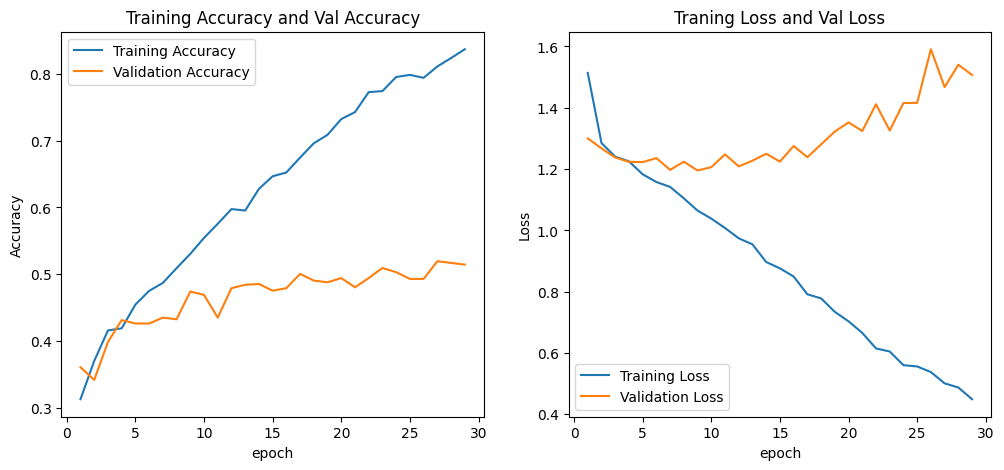

In [20]:
history = history.history
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
epoch = range(1 , len(loss) + 1)

import matplotlib.pyplot as plt

plt.figure(figsize  = (12 , 5))
plt.subplot(121)
plt.plot(epoch , accuracy , label = 'Training Accuracy')
plt.plot(epoch , val_accuracy , label = 'Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy and Val Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epoch , loss , label = 'Training Loss')
plt.plot(epoch , val_loss , label = 'Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Traning Loss and Val Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


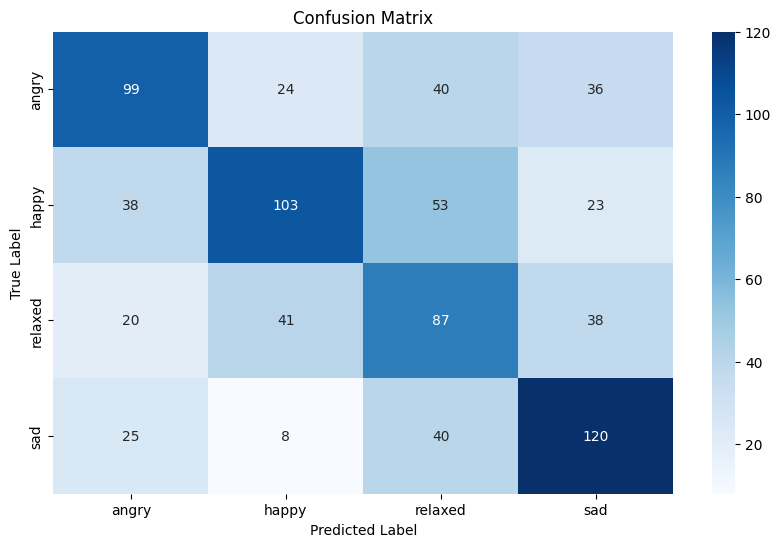

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = []
y_true = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10 , 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [23]:
import tensorflow as tf
model.save(r'C:\Users\U2SR\Desktop\Udemy\tensorflow-cnn\tensorflow_dataset.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


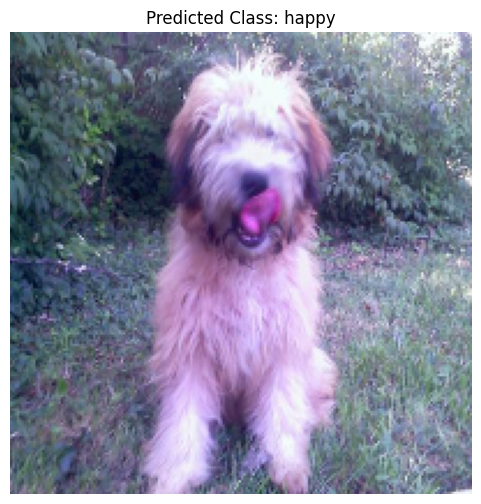

Predicted probabilities (in %): [[6.8425565e+00 9.3029144e+01 1.2436761e-01 3.9368179e-03]]


In [32]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#테스트 이미지 경로
test_image_path = r'C:\Users\U2SR\Desktop\Udemy\tensorflow-cnn\Dog Emotion\happy\0dula1RWC0ZyjlrqEwuVHgtxHp5kme443.jpg'

#이미지 로드,전처리 함수 구현
def load_and_preprocess_image(image_path, target_size):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("이미지 error인것같네요")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, target_size[:2])
    img_array = np.asarray(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

target_size = (200, 200)
test_img_array = load_and_preprocess_image(test_image_path, target_size)

predictions = model.predict(test_img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

#클래스 이름 정의
class_names = {
    0: 'angry',
    1: 'happy',
    2: 'relaxed',
    3: 'sad'
}

predicted_class_name = class_names[predicted_class]

plt.figure(figsize=(6, 6))
plt.imshow(test_img_array[0].astype('uint8'))
plt.title(f'Predicted Class: {predicted_class_name}')
plt.axis('off')
plt.show()

print(f'Predicted probabilities (in %): {predictions * 100}')